# Predicting Final Grade

In [1]:
import sys
sys.path.append('..'),
from src import splitxy
from src import listfun
from src import plotSquareData

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import (
    cross_validate,
    train_test_split,
    RandomizedSearchCV
)
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import urllib.request
import zipfile

## Introduction

Education remains one of the most vital and fundamental resources in the world. There is an active body of research that works to explore the relation between education and other societal factors such as economic growth where current research suggests that better education lends itself to better economic growth, and perhaps more importantly for individuals, a higher individual income (Roser & Ortiz-Ospina, 2016). 

There are many other reasons why people may care about their grade besides raw income. A student may want to get into a prestigious university where the entrance requirement is very high (of course, the underlying motivation could be income, but the current motivation is a top university). Alternatively, it may be as simple as getting the satisfaction of seeing a high mark on your report card. Being able to accurately predict your grade allows you to plan in advance to determine if you need extra assistance in a particular subject, or if you are currently on track to meet or exceed the grade you desire. Unfortunately, this is not an easy task. There are many potential factors that can affect your performance, and given that each student has their own unique circumstances, this makes the task of predicting monumental. On the other hand, there are also many features that are common among students, and helps serve as a common ground in being able to predict your final grade.

For this project, we're conducting a multi-variable regression analysis on the *Student Performance* dataset. The original dataset, which was recorded on the UCI ML Repo (see citation), was split into two individual datasets, respectively with students' final grades in Portuguese and Math. For this project, we're only focusing on the Math dataset. First used in 2008 by Cortez and Silva, this dataset was collected for use in decision trees, neural networks, SVMs and Random Forest. The dataset has an very large number of potentially useful features. There are 30 features and 3 outputs; however, for the purposes of this analysis, we will only focus on 9 features with varying levels of intuitive correlation with the final end of year grade G3, mostly consisting of social factors. For instance, the feature "study time", at a glance, seems like there will be a positive correlation with final grade while the feature "romantic" is not as straightforward to tell. 

The dataset we will be using contains the following features (the type of feature is given by the UCI ML Repo):
 * study time: The number of hours spend studying per week. It is a numeric feature where each number is associated with a range of hours spent studying (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours).
 * Pstatus: Whether the parents of the student are currently living together or seperated (Binary feature: T = living together, A = apart)
 * Medu: Numeric representations of the mother's education level  (numeric: 0 - none, 1 - primary education (4th grade), 2 - 5th to 9th grade, 3 - secondary education or 4 - higher education)
 * Fedu: Numeric representations of the father's education level  (numeric: 0 - none, 1 - primary education (4th grade), 2 - 5th to 9th grade, 3 - secondary education or 4 - higher education)
 * Mjob: The mother's job (Categorical: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')
 * Fjob: The father's job (Categorical: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')
 * goout: A representation of how often the student goes out with friends (numeric: from 1 - very low to 5 - very high)
 * travel time: how long it takes to get to school (numeric: 1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour)
 * romantic: Whether or not the student is in a romantic relationship (Binary: yes and no)
 * G3: The final grade of the student at the end of the year represented by a 0-20 scale (numeric: from 0-20 where 0 represents 0-5% and 20 represents 95-100%)
 
Thus, we are interested in looking to answer the following question: **Can we predict a student's final grade (denoted by "G3" in the dataset) given the above features**.


## Exploratory Data Analysis

In [2]:
#inspiration for learning how to download from web taken from https://stackoverflow.com/questions/41218216/using-pandas-to-download-load-zipped-csv-file-from-url
URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip'
location, _ = urllib.request.urlretrieve(URL)
compressed_file = zipfile.ZipFile(location)
csv_file = compressed_file.open('student-mat.csv')
df = pd.read_csv(csv_file,sep = ";")
pd.set_option("display.max_rows", 10, "display.max_columns", None)
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10


In [3]:
#save a copy of the dataframe 
df.to_csv('../data/raw/student-mat.csv', index=False)

In [4]:
train_df, test_df = train_test_split(df, test_size = 0.2, random_state=100)

#make training and testing split
desiredfeatures = ["studytime", "Pstatus", "Medu", "Fedu", "Mjob", "Fjob", "goout","romantic","traveltime"]
X_train, y_train = splitxy.splitxy(train_df, desiredfeatures, "G3")
X_test, y_test = splitxy.splitxy(test_df, desiredfeatures, "G3")

We decided on a train test split of 80% training and 20% testing. This was because the number of samples in the dataset where moderately low (396) so we wanted more samples to train on. 

In [5]:
describer = X_train.describe(include="all")
describer.style.set_caption("Figure 1.0. A table desplaying the most common values of each categorical variable along side percentiles of numerical variables")

,studytime,Pstatus,Medu,Fedu,Mjob,Fjob,goout,romantic,traveltime
count,316.000000,316,316.000000,316.000000,316,316,316.000000,316,316.000000
unique,nan,2,nan,nan,5,5,nan,2,nan
top,nan,T,nan,nan,other,other,nan,no,nan
freq,nan,290,nan,nan,115,174,nan,209,nan
mean,2.047468,nan,2.797468,2.547468,nan,nan,3.120253,nan,1.436709
std,0.843816,nan,1.067616,1.090053,nan,nan,1.091715,nan,0.680182
min,1.000000,nan,1.000000,0.000000,nan,nan,1.000000,nan,1.000000
25%,1.000000,nan,2.000000,2.000000,nan,nan,2.000000,nan,1.000000
50%,2.000000,nan,3.000000,2.500000,nan,nan,3.000000,nan,1.000000
75%,2.000000,nan,4.000000,4.000000,nan,nan,4.000000,nan,2.000000


Using panda's describe all and styler to make a table, we can find many useful pieces of information for all of our features. For numerical features, we can see interesting pieces of info such as the average mother education is higher than the average father education. Furthermore, for categorical variables, we can see interesting info such as the most frequent parent status in our training set is that they are still living together and most people are not in a romantic relationship.

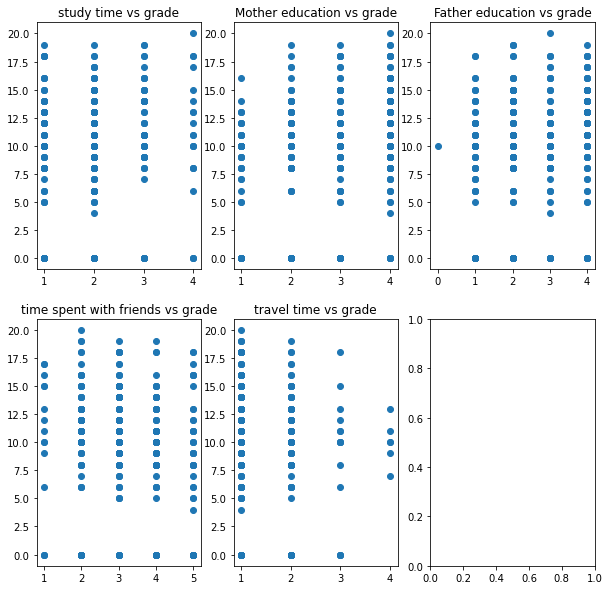

(array([[<AxesSubplot:title={'center':'study time vs grade'}>,
         <AxesSubplot:title={'center':'Mother education vs grade'}>,
         <AxesSubplot:title={'center':'Father education vs grade'}>],
        [<AxesSubplot:title={'center':'time spent with friends vs grade'}>,
         <AxesSubplot:title={'center':'travel time vs grade'}>,
         <AxesSubplot:>]], dtype=object),
 <Figure size 720x720 with 6 Axes>)

In [6]:
desiredFeatures = ["studytime", "Medu", "Fedu", "goout", "traveltime"]
titles = ["study time vs grade", "Mother education vs grade", "Father education vs grade", 
                                     "time spent with friends vs grade", "travel time vs grade"]
txt = "Figure 2 A series of plots examining the numeric features compared to predicted grade"
plotSquareData.plot_square_data(X_train, y_train, desiredFeatures, titles, txt) 

From these numeric features, we can see that for the most part, there is no relation between these features and predicted grade. The only truly interesting thing to note is that with higher travel time, it seems that the range of grades gets narrower and narrower such that the low end of the range is higher than lower values of travel time, but the high end of the range is also much lower compared to lower values of travel time. Of course, it is difficult to say whether this is true or not given the low number of samples for higher travel time.

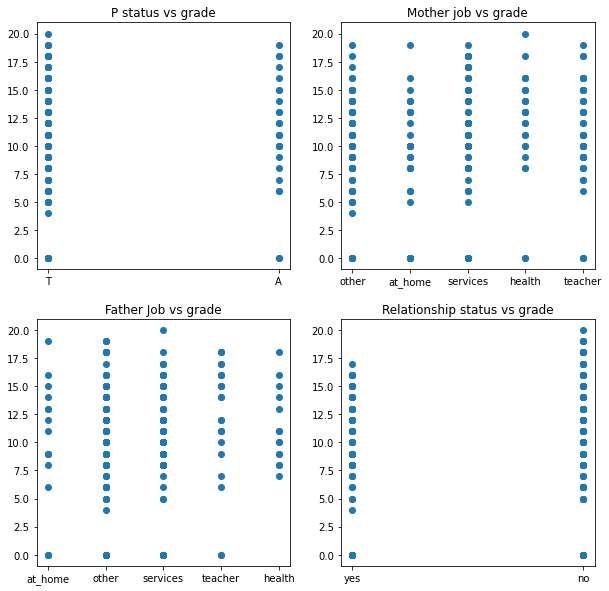

(array([[<AxesSubplot:title={'center':'P status vs grade'}>,
         <AxesSubplot:title={'center':'Mother job vs grade'}>],
        [<AxesSubplot:title={'center':'Father Job vs grade'}>,
         <AxesSubplot:title={'center':'Relationship status vs grade'}>]],
       dtype=object),
 <Figure size 720x720 with 4 Axes>)

In [7]:
desiredFeatures = ["Pstatus", "Mjob", "Fjob", "romantic"]
titles = ["P status vs grade", "Mother job vs grade", "Father Job vs grade", "Relationship status vs grade"]
txt = "Figure 3 A series of histograms examining the distribution of categorical features"
plotSquareData.plot_square_data(X_train, y_train, desiredFeatures, titles, txt)

From this exploratory categorical variable analysis, we can see that for some of these variables, we have a big imbalance between classes. This is especially prominent in P status and Father job. The consequence of this is that the coefficient end up not being very useful in terms of predicting grades as, for example, P status = t may have lots of representation in high and low categories. Furthermore, given the low amount of P status = A, the model we use might misrepresent the data if all of the "A" values end up being either high or low grades, and not a mix of both when we apply our model to the test set..

## Methods

Since what we are trying to predict is a quantitative varible based on several variables, it is clear we are aiming for regression analysis. Particularly, the regresion methods from DSCI 110 were knn and least square, where we think the best of the two may be least squares regression. This is namely due to the fact that we hueristically expect quite linear result from many of these variables. Within the scikit-learn package, there are a few options for least squares regression, Linear Regression and Ridge Regression. We will be using Ridge regression, which is functionally similar to linear regression, but manages the coefficients in a manner where none are exceptionally large.


In [8]:
#preprocess the data to make sure the scaling is correct and the categorical variables are encoded properly
numeric_features = ["studytime", "Medu", "Fedu", "goout", "traveltime"]
categorical_features = ["Mjob", "Fjob"]
binary_features = ["Pstatus", "romantic"]

preprocessor = make_column_transformer(
    (make_pipeline(SimpleImputer(), StandardScaler()), numeric_features), 
    (make_pipeline(SimpleImputer(strategy="constant", fill_value="missing"), OneHotEncoder(handle_unknown="ignore", sparse=False)), categorical_features),
    (make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder(drop="if_binary", dtype=int)), binary_features),
)


Since we have a few categorical variables and binary variables, we need to encode the data in a manner our model can read, and we decided on one hot encoding given its simplicity. Lastly, while there is no missing data in the dataset, we thought it would be a good idea to use simple imputer in case we run into a situation were there is missing data in our test set or if we decide to use this model on another dataset with the same features.

In [9]:
#create the pipeline to preprocess our data and apply linear regression
pipelr = make_pipeline(preprocessor, Ridge(random_state=123))

hyperparams = np.exp(np.random.uniform(-3, 3, 10))

param_dist = {"ridge__alpha": hyperparams}

rand_search = RandomizedSearchCV(pipelr, param_dist, n_jobs = -1, scoring = "neg_root_mean_squared_error")
rand_search.fit(X_train, y_train)

print(rand_search.best_params_)
print(rand_search.best_score_)

{'ridge__alpha': 10.048178262485676}
-4.6232191575980055


In [10]:
df_results = pd.DataFrame(rand_search.cv_results_)
df_results2 = df_results[df_results.rank_test_score < 5].drop(["mean_score_time",
                                                             "std_score_time",
                                                             "split0_test_score",
                                                             "split1_test_score",
                                                             "split2_test_score",
                                                             "split3_test_score",
                                                             "split4_test_score"], axis=1)
df_results2

,mean_fit_time,std_fit_time,param_ridge__alpha,params,mean_test_score,std_test_score,rank_test_score
1,0.025500,0.000949,4.404045,{'ridge__alpha': 4.404044724167825},-4.641092,0.294354,2
2,0.025199,0.003868,3.715739,{'ridge__alpha': 3.7157390867006486},-4.644293,0.293786,3
3,0.023300,0.002293,10.048178,{'ridge__alpha': 10.048178262485676},-4.623219,0.297197,1
4,0.019900,0.001656,2.845597,{'ridge__alpha': 2.8455972981295665},-4.648846,0.292938,4


Ridge Regression takes in 1 hyperparameter that controls the complexity of the model. With higher levels of alpha, we have lower model complexity. We do 5 fold cross validation because it is not too computationally expensive, and we do randomizedsearch because it is better at exploring hyperparameters than gridsearch. The default scoring method of sklearn regression is R^2 score, but it found that RMSE score is easier to interpret in the context of this dataset, therefore we pass in RMSE as the scoring function. While we pass in neg RMSE, it is just as easy to interpret since we just want to look for how close the score is to 0, where the closer it is to 0, the less error it has. Thanks to scikit-learn, we have an easy method of finding out what our best performing hyperparameters are. In this case, the best performing hpyerparameter was a Ridge_alpha value of 9.93, with a mean test error of 4.623

## Results


Now that we have our best performing hyperparameter, we can pass in the best param into our model. Then we can train that model on the entire training set and evaluate it on our testing set.

In [18]:
pipelr2 = make_pipeline(preprocessor, Ridge(alpha = rand_search.best_params_['ridge__alpha']))
pipelr2.fit(X_train, y_train)

predicted = pipelr2.predict(X_test)
rms = mean_squared_error(y_test, predicted, squared=False)
df_final = df_results[df_results.rank_test_score == df_results.rank_test_score.min()].drop(["mean_score_time",
                                                                                             "std_score_time",
                                                                                             "split0_test_score",
                                                                                             "split1_test_score",
                                                                                             "split2_test_score",
                                                                                             "split3_test_score",
                                                                                             "split4_test_score"], axis=1)
df_final["final score"] = -rms
df_final

,mean_fit_time,std_fit_time,param_ridge__alpha,params,mean_test_score,std_test_score,rank_test_score,final score
3,0.0233,0.002293,10.048178,{'ridge__alpha': 10.048178262485676},-4.623219,0.297197,1,-3.844722


In [20]:
print("The final RMSE error is:", rms) 

The final RMSE error is: 3.8447223526273606


According to our best model, our RMSE is 3.83 which is better than the value we obtained from cross validation. This suggests one of two things, 1. either our model generalized well on this new dataset, or 2. we happened to be lucky for the test set and the model wont generalize well to other datasets in practice.

Text(0.5, -0.05, 'Figure 4. A plot displaying the relation between the predicted grade and the actual grade')

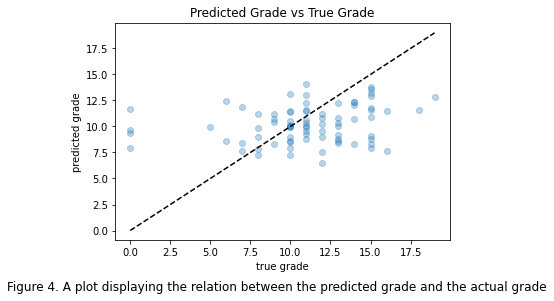

In [13]:
plt.title("Predicted Grade vs True Grade")
plt.scatter(y_test, predicted, alpha=0.3)
grid = np.linspace(y_test.min(), y_test.max(), 1000)
plt.plot(grid, grid, "--k")
plt.xlabel("true grade")
plt.ylabel("predicted grade")
txt = "Figure 4. A plot displaying the relation between the predicted grade and the actual grade"
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=12)

The regression graph shows that we predict roughly the same values no matter what the true grade of the student happens to be. Only at the very high true grades do we see the predictions start to increase, albeit marginally. The range at low values is a bit larger at about 5-12.5 while at high true grades, it is about 8-13.

In [14]:
#ohe_columns = listfun.list_abs(preprocessor, "pipeline-2", "onehotencoder", categorical_features)
ohe_columns = listfun.list_abs(preprocessor, "pipeline-2", "onehotencoder", categorical_features)
ohe_columns2 = listfun.list_abs(preprocessor, "pipeline-3", "onehotencoder", binary_features)

new_columns = numeric_features + ohe_columns + ohe_columns2

df_coeff = pd.DataFrame(
    data={
        "features": new_columns,
        "coefficients": pipelr2.named_steps["ridge"].coef_,
    }
)

In [15]:
ohe_columns2

['Pstatus_T', 'romantic_yes']

In [16]:
df_coeff.sort_values("coefficients",ascending=False)

,features,coefficients
1,Medu,0.877669
6,Mjob_health,0.870098
14,Fjob_teacher,0.773507
8,Mjob_services,0.459625
0,studytime,0.318796
...,...,...
9,Mjob_teacher,-0.457726
5,Mjob_at_home,-0.560445
15,Pstatus_T,-0.591030
3,goout,-0.622587


Looking at what feature make the most impact in predicting high true grades, we see that the mother has a very large impact on the predicted grades. Depending on the mother's job, it can positively influence the final grade or it can negatively impact it. We also see that being in a romantic relationship seems to be the most impactful at predicting lower grades. Interestingly, study time isn't the most influential part feature despite intuition telling us that with higher study time, we would except to get higher grades.

## Discussion:

Using the 9 features we presented above, we were able to create a linear regression model with an RMSE error of 3.83. Given the scale of the target variable (G3) is 0-20, we find that this error is very high; therefore, we find that using features predominately consisting on demographic and social factors would not lend itself well to accurately predicting grade. This high error can be seen in our regression graph, where the predictions seem to be consistent in the 5-13 range no matter what the true grade of the student is. This can be interpreted as a positive outcome, as it suggests that your performance in school is only mildly impacted by demographic (e.g. parent job) and social (e.g. romantic) factors, which means more emphasis is likely placed on how much effort you apply to the course.

When examining the coefficients, this does reflect some of the finding found by Pritchard & Wilson (2003), as they found that parent's education seemed to be one of the most influential factors in predicting high grades as we see that mother's education is the third highest predictor of high grades. On the other hand, we see that this is only true of the mother's education, since the father's education level seems to be quite unimpactful. It is interesting to see how much influence the mother has when compared to the father. Given that we do not see coefficients regarding the father much in these top 5 or bottom 5 coefficients, we can say that the father doesn't have much of an impact at all unless he happens to work as a teacher. Lastly, we expected goout and romantic to have a negative correlation with your final grade as you are likely to be spending your time with your peers rather than studying. This expectation was reflected strongly in the analysis.

A future question we could ask using this dataset is how effective pure academic features such as study time and number of classes failed perform when trying to predict final grade. We see that study time, while we intuitively thought would have a major positive correlation with high grades, is only the 5th highest coefficient. This suggests that it is quite possible that demographic and social factors may have a higher impact than we see from this report, such that it is absolutely required that we look at social, demographic, and academic factors at the same time. Is academic factors dominant in predicting grade or does demographic and social factors have a higher impact than it seems?


## Citations

Cortez, P. (2014). Student Performance. UCI Machine Learning Repository.

Cortez,  P.,  &  Silva, A.  (2008).  Using  data  mining  to  predict  secondary school  student  performance.  15th European Concurrent Engineering Conference 2008,  ECEC 2008 - 5th  Future Business Technology Conference, FUBUTEC 2008, 2003(2000), 5–12. 

Roser, M., & Ortiz-Ospina, E., (2016) - "Global Education". Published online at OurWorldInData.org. Retrieved from: 'https://ourworldindata.org/global-education' [Online Resource]

Pritchard, M. E., & Wilson, Gregory S. (Gregory Scott). (2003). Using emotional and social factors to predict student success. Journal of College Student Development, 44(1), 18-28. https://doi.org/10.1353/csd.2003.0008